In [1]:
import numpy as np
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

In [2]:
log_params = {"A": 11.364949138901626, "mu_m": 0.02570911423727819, "lambda": 10.42070585368556}
incubation_time = 7.5 * 60 * 60 # from Positions.xlsx
def logistic_growth_rate(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    gr = 4 * mu_m * np.exp(4 * mu_m / A * (l - t) + 2) / (1 + np.exp(4 * mu_m / A * (l - t) + 2))**2
    return gr / 60

def logistic(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    log_B = A / (1 + np.exp(4 * mu_m / A * (l - t) + 2))
    return np.exp(log_B)

def tm_logistic(log_params):
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']   
    return A / (2 * mu_m) + l

In [3]:
edt = np.load('../../2023_11_28_tweez/Pos 5/edt.npy')
#edt = np.load('../../2023_11_30_tweez/Pos 15/results/edt.npy')
#edt = np.load('results/edt.npy')
nt,nx,ny = edt.shape
print(edt.shape)

(196, 1024, 1024)


In [4]:
from skimage.io import imread

im = imread('../../2023_11_28_tweez/Pos 5/10x_1.0x_pAAA_TiTweez_1_MMStack_Pos5.ome.tif')
#im = imread('../../2023_11_30_tweez/Pos 15/10x_1.0x_MC4100_pAAA_TiTweez_1_MMStack_Pos15.ome.tif')
im = im.transpose([0,2,3,1])
im = im[20:,:,:,2:].astype(float)
#im = imread('10x_1.0x_MC4100_pLPT20&41_TiTweez_2_MMStack_Pos12.ome.tif')
#im = im[:,:,:,1:]
print(im.shape)

<tifffile.TiffFile '10x_1.0x_pAAA_Ti…ck_Pos5.ome.tif'> MMStack series is missing files. Returning subset (1, 216, 5, 1) of (13, 216, 5, 1)


(196, 1024, 1024, 3)


In [5]:
from scipy.ndimage import gaussian_filter

# Background correction
nt,nx,ny,nc = im.shape
bg = im[:,-256:,-256:,:].mean(axis=(1,2))
bgvar = im[:,-256:,-256:,:].var(axis=(1,2))

for t in range(nt):
    for c in range(nc):
        im[t,:,:,c] = gaussian_filter(im[t,:,:,c], 1) - bg[t,c]

im[im<0] = 0

In [6]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 256

crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
crop_im = np.zeros((nt,w+2*pad,h+2*pad,3))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    tim = im[t,:,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]
    crop_im[t,:,:] = tim[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad,:]

452 458
(196, 964, 970)


In [7]:
rs = np.arange(int(np.nanmax(crop_edt)))
rcov = np.zeros((nt,len(rs),2,2)) + np.nan
rdcov = np.zeros((nt,len(rs),2,2)) + np.nan
rkymo = np.zeros((nt,len(rs),2)) + np.nan
for t in range(nt):
    for ir in range(len(rs)):
        tedt = crop_edt[t,:,:]
        tim0 = crop_im[t,:,:,0]
        tim1 = crop_im[t,:,:,1]
        x = tim0[np.abs(tedt-rs[ir])<8]
        y = tim1[np.abs(tedt-rs[ir])<8]
        if len(x)>10:
            C = np.cov(x,y)
            rcov[t,ir,:,:] = C
            if t>75:
                tim00 = crop_im[t-1,:,:,0]
                tim10 = crop_im[t-1,:,:,1]
                x0 = tim00[np.abs(tedt-rs[ir])<8]
                y0 = tim10[np.abs(tedt-rs[ir])<8]
                rdcov[t,ir,:,:] = np.cov(x-x0, y-y0)
        if len(x)>0:
            rkymo[t,ir,0] = x.mean()
            rkymo[t,ir,1] = y.mean()

25.31985741074852


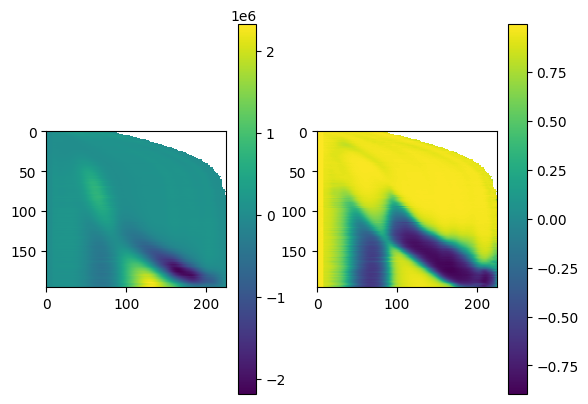

In [678]:
plt.subplot(1, 2, 1)
plt.imshow(rcov[:,:,0,1]) #, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.subplot(1, 2, 2)
#plt.imshow(rcov[:,:,1,1]) #, cmap='bwr', vmin=-1, vmax=1)
#plt.colorbar()
rcorr = rcov[:,:,0,1] / np.sqrt(rcov[:,:,0,0] * rcov[:,:,1,1])
plt.imshow(rcorr)
plt.colorbar()

print(np.nanmin(rdcov[:,:,1,1]))

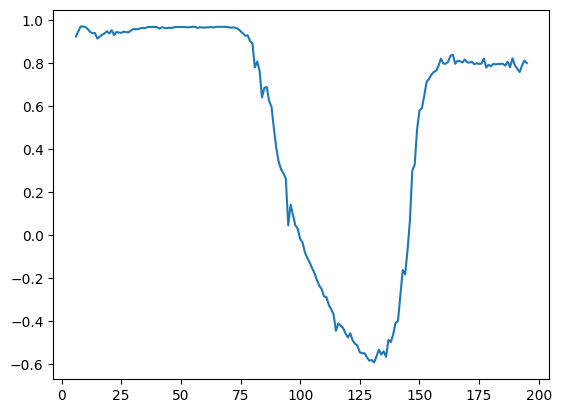

In [450]:
plt.plot(rcorr[:,100])

In [1]:
import numpy as np
from scipy.linalg import eigvalsh

def solve_least_squares_regularized(D, C, lambda_A=1.0, lambda_B=0.01):
    A_list = []
    B_list = []

    for D_t, C_t in zip(D, C):
        C_t = np.array(C_t)
        D_t = np.array(D_t)

        # Ensure C_t is symmetric
        C_t = (C_t + C_t.T) / 2

        # Vectorize the matrix equation E = D - B
        E_t = D_t - np.zeros_like(D_t)  # Start with B = 0

        # Define the Kronecker products
        K1 = np.kron(C_t.T, np.eye(C_t.shape[0]))
        K2 = np.kron(np.eye(C_t.shape[0]), C_t)

        # Regularized least squares problem
        K = K1 + K2
        regularization_term = lambda_A * np.eye(K.shape[0])
        A_vec = np.linalg.lstsq(K + regularization_term, E_t.flatten(), rcond=None)[0]
        
        # Reshape the result back to matrix form
        A_t = A_vec.reshape(C_t.shape)

        # Compute B
        B_t = D_t - A_t @ C_t - C_t @ A_t.T

        B_t = B_t + lambda_B * np.eye(B_t.shape[0])

        # Ensure B_t is positive definite with regularization
        #min_eig = np.min(eigvalsh(B_t))
        #if min_eig <= 0:
        #    B_t += (-min_eig + lambda_B) * np.eye(B_t.shape[0])

        A_list.append(A_t)
        B_list.append(B_t)

    return A_list, B_list

# Example usage
A = np.zeros((nt,len(rs),2,2)) + np.nan
B = np.zeros((nt,len(rs),2,2)) + np.nan
for r in range(len(rs)):
    D_data = dcdt[100:,r,:,:]  # List of 2x2 numpy arrays for D(t)
    C_data = rcov[100:,r,:,:]  # List of 2x2 numpy arrays for C(t)

    A_list, B_list = solve_least_squares_regularized(D_data, C_data, lambda_A=5e2, lambda_B=5e2)
    A[100:,r,:,:] = np.array(A_list)
    B[100:,r,:,:] = np.array(B_list)


NameError: name 'nt' is not defined

In [2]:
plt.imshow(B[:,:,0,0])
plt.colorbar()

NameError: name 'plt' is not defined

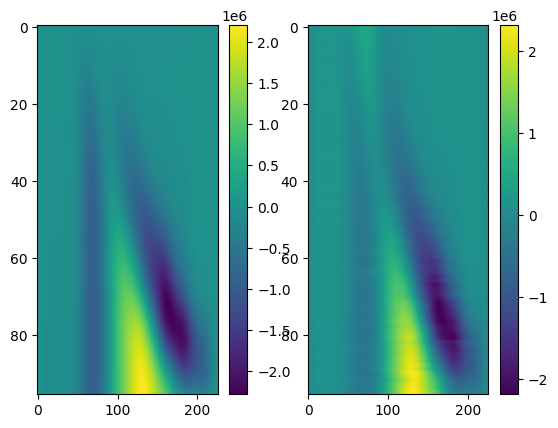

In [701]:
ntt,nr,_,_ = A.shape
C = rcov
AA = A.reshape(ntt*nr,2,2)
CC = C.reshape(ntt*nr,2,2)
D = np.matmul(AA, CC) + np.matmul(CC, AA.transpose((0,2,1)))
BB = np.zeros((ntt,nr,2,2))
BB[:,:,0,0] = B[:,:,0,0]
BB[:,:,1,1] = B[:,:,1,1]
D = D.reshape((ntt,nr,2,2)) # + BB

plt.subplot(1, 2, 1)
plt.imshow(np.cumsum(D[100:,:,0,1], axis=0), aspect='auto')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(rcov[100:,:,0,1], aspect='auto')
plt.colorbar()

#plt.plot(np.cumsum(D[:,0,1]))
#plt.plot(D[:,1,0])
#plt.plot(D[:,1,1])
#plt.plot(rcov[75:,100,1,1])
#plt.plot(rcov[75:,100,0,1])
#plt.plot(D_data[:,0,0], '--')
#plt.plot(D_data[:,0,1], '--')
#plt.plot(D_data[:,1,0], '--')
#plt.plot(D_data[:,1,1], '--')

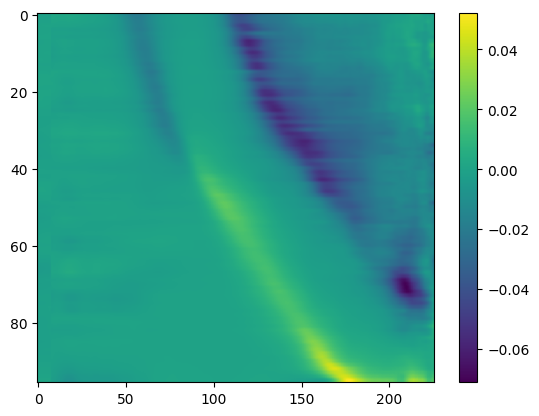

In [699]:
cov01 = B[:,:,0,1]
var0 = B[:,:,0,0]
var1 = B[:,:,1,1]
corrw = cov01 / np.sqrt(var0 * var1)
plt.imshow(corrw[100:,:], aspect='auto')
plt.colorbar()

In [230]:
nt,nx,ny = crop_edt.shape
offset = incubation_time / 60 / 100
ntt = nt + int(offset)
crop_edt = np.zeros((ntt,nx,ny))
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
cx,cy = nx/2, ny/2
R = np.sqrt((x-cx)**2 + (y-cy)**2)
for t in range(ntt):
    area = logistic(t * 10 * 60 - offset * 10 * 60, log_params)
    radius = np.sqrt(area / np.pi)
    crop_edt[t,:,:] = radius - R
    tedt = crop_edt[t,:,:]
    tedt[tedt<0] = 0 
    crop_edt[t,:,:] = tedt

In [231]:
def split_image_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width, channels = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size, channels))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for c in range(channels):
                for t in range(nt):
                    blocks[t, i, j, :, :, c] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size, c]
    return blocks

def split_edt_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for t in range(nt):
                blocks[t, i, j, :, :] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
    return blocks

edt_blocks = split_edt_into_blocks(crop_edt, 16)
im_blocks = split_image_into_blocks(crop_im, 16)
crop_edt_low = edt_blocks.mean(axis=(3,4))
crop_im_low = im_blocks.mean(axis=(3,4))
print(crop_im_low.shape)


(216, 51, 51, 3)


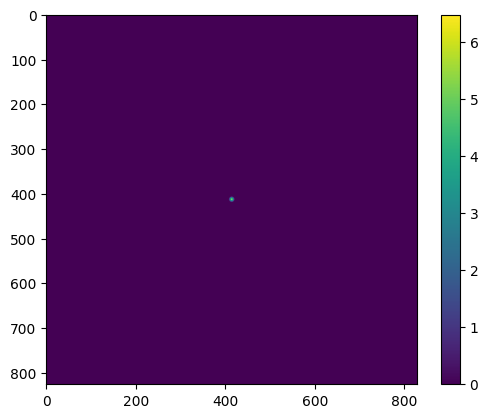

In [232]:
plt.imshow(crop_edt[20,:,:])
plt.colorbar()

In [233]:
#from skimage.transform import downscale_local_mean

#print(crop_edt.shape)
#crop_edt_low = np.zeros((ntt,52,52))
#crop_im_low = np.zeros((nt,52,52,3))

#for t in range(ntt):
#    edt_low = downscale_local_mean(crop_edt[t,:,:], (16,16))
#    crop_edt_low[t,:,:] = edt_low

#for t in range(nt):
#    im_low = downscale_local_mean(crop_im[t,:,:], (16,16,1))
#    crop_im_low[t,:,:] = im_low

crop_edt = crop_edt_low
crop_im = crop_im_low
print(crop_edt.shape)
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape

crop_im[crop_edt[int(offset):,:,:]==0] = np.nan

(261, 51, 51)


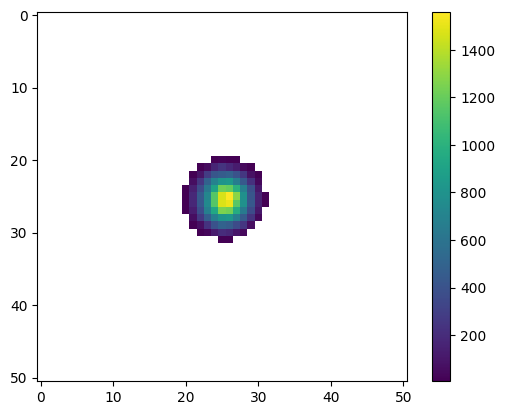

In [234]:
plt.imshow(crop_im[0,:,:,0])
plt.colorbar()

In [672]:
def dudt(u, t, tmask, phi, kappa, gamma0, gamma1, dx, t0):
    du = np.zeros((nx,ny))
    #du[tmask] += phi * 1 / (1 + np.exp((t - t0) / dt)) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='nearest')
    du += kappa * delu / dx / dx
    #du[tmask] -= gamma * u[tmask] * 1 / (1 + np.exp((t - t0) / dt))
    gr = logistic_growth_rate(t - offset * 10 * 60, log_params)
    du[tmask] -= gamma0 * u[tmask] * gr
    return du.ravel()

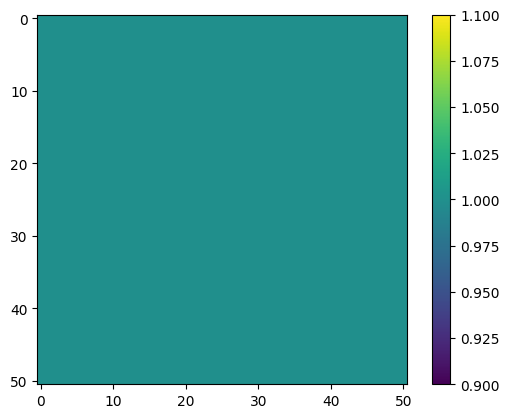

In [879]:
p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
def dpdt(p, t, tmask, phi0, phi1, gamma):
    p = p.reshape((nx,ny,2))
    dpdt = np.zeros_like(p)
    dpdt[:,:,0] = phi0 - gamma * p[:,:,0] #- km0 * p[:,:,0]
    dpdt[:,:,1] = phi1 - gamma * p[:,:,1] #- km1 * p[:,:,1]
    #dpdt[:,:,2] = km0 * p[:,:,0] - gamma * p[:,:,2]
    #dpdt[:,:,3] = km1 * p[:,:,1] - gamma * p[:,:,3]
    for c in range(2):
        cdpdt = dpdt[:,:,c]
        cdpdt[tmask==0] = 0
        dpdt[:,:,c] = cdpdt
    return dpdt.ravel()

plt.imshow(p0[:,:,2])
plt.colorbar()

In [901]:
from scipy.integrate import odeint

def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

def shill(x, K, n):
    return 0.5 + n * (x - K) / 4 / K - n * (x - K)**2 / 8 / K**2

def step(x, K):
    return (x > K) * 1

def hill2(x, K0, K1, n):
    return (x/K0)**n / (1 + (x/K0)**n + (x/K1)**n)    

def solve_gene_expression(u, alpha0, alpha1, beta0, beta1, gamma_fp, K0, K1, n, h, ts):
    nt = len(ts)
    print(nt)
    t0 = int(ts[0] * dt)
    p0 = crop_im[int(t0 / 60 / 10),:,:,:]
    p = np.zeros((nt+1,nx,ny,2))
    p[0,:,:,0] = p0[:,:,0]
    p[0,:,:,1] = p0[:,:,1]
    #p[0,:,:,2] = p0[:,:,0]
    #p[0,:,:,3] = p0[:,:,1]
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[int(t0 / 60 / 10 + offset),:,:]>0 # crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10 + offset),:,:] # crop_edt[0,:,:]
        #phi0 = alpha0 * step(u[ti,:,:], K0) + beta0
        #phi1 = alpha1 * step(u[ti,:,:], K1) + beta1
        phi0 = alpha0 * hill(u[ti,:,:], K0, n) + beta0
        phi1 = alpha1 * hill(u[ti,:,:], K1, n) + beta1
        #phi0 = alpha0 # * u[ti,:,:] + beta0
        #phi1 = alpha1 # * u[ti,:,:] + beta1
        #ukm0 = km0 * hill(u[ti,:,:], K, n)
        #ukm1 = km1 * hill(u[ti,:,:], K, n)
        dp = dpdt(p[ti,:,:,:], t, tmask>8, phi0 * h, phi1 * h, gamma_fp)
        p[ti+1,:,:,:] = p[ti,:,:,:] + dt * dp.reshape(nx,ny,2)
        mask[ti+1,:,:] = tmask
    pmask = np.zeros_like(p) + np.nan
    for c in range(2):
        cp = p[:,:,:,c]
        cpmask = pmask[:,:,:,c]
        cpmask[mask>0] = cp[mask>0]
        pmask[:,:,:,c] = cpmask
    return pmask

def solve_diffusion(kappa, gamma0, gamma1, u0, dx, dt, t0, ts):
    nt = len(ts)
    print(nt)
    u = np.zeros((nt+1,nx,ny))
    #u0 = np.zeros((nx,ny)) + 1
    u[0,:,:] = u0
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10),:,:] # crop_edt[0,:,:]
        du = dudt(u[ti,:,:], t, tmask>8, 0, kappa, gamma0, gamma1, dx, t0)
        u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
        mask[ti+1,:,:] = tmask

    umask = np.zeros_like(u) + np.nan
    umask[mask>0] = u[mask>0]
    return umask



In [14]:
from scipy.signal import savgol_filter

def compute_rho(x, y, w=21):
    rho_01 = x / y # pmask[:,:,:,0] / pmask[:,:,:,1]
    #rho_02 = pmask[:,:,:,0] / pmask[:,:,:,2]
    #rho_12 = pmask[:,:,:,1] / pmask[:,:,:,2]

    lrho_01 = np.log(rho_01)
    dslrho_01 = savgol_filter(lrho_01, w, 3, deriv=1, axis=0)
    #lrho_02 = np.log(rho_02)
    #dslrho_02 = savgol_filter(lrho_02, w, 3, deriv=1, axis=0)
    #lrho_12 = np.log(rho_12)
    #dslrho_12 = savgol_filter(lrho_12, w, 3, deriv=1, axis=0)

    #return rho_01,rho_02,rho_12, dslrho_01,dslrho_02,dslrho_12
    return rho_01,dslrho_01
    

In [305]:
from scipy.interpolate import interp1d

def residuals(x):
    print(np.exp(x))
    ha,gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.exp(x)
    #umask,pmask = solve(alpha0, alpha1, alpha2, beta0, beta1, beta2, kappa, gamma, dx, dt, ts)
    ts = np.arange(0, np.floor(32 * 60 * 60 / dt + offset * 10 * 60 / dt))
    umask = solve_diffusion(kappa, gamma, 0, u0, dx, dt, t0, ts)
    uu = umask[:-1,:,:]
    ts2 = np.arange(np.floor(12 * 60 * 60 // dt), np.floor(32 * 60 * 60 // dt))

    idx0 = int(12 * 60 * 60 // dt // 120)
    print(idx0)
    #resid = p - crop_im[idx0:144,:,:,:]
    tidx0 = idx0
    tidx1 = int(32 * 60 * 60 // dt // 120)
    r = crop_edt[tidx0+int(offset),:,:]
    rr = r / crop_edt.max()
    #x0,x1,C = ha,1,-hb
    #h = C * rr * rr * rr + (-2 * C + x0 - x1) * rr * rr + (C - 2 * (x0 - x1)) * rr + x0
    sigma = ha
    h = np.exp(-(rr-1)**2/sigma)
    h = (h - h.min()) / (h.max() - h.min())
    h[r<0] = 0
    print(f'max(h),min(h) = {np.nanmin(h), np.nanmax(h)}')
    pmask = solve_gene_expression(uu[ts >= 12 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], alpha0, alpha1, beta0, beta1, gamma_fp, K0, K1, n, h, ts2)

    print(np.nanmin(pmask))
    print(pmask.shape)
    p = pmask[:-1:120,:,:,:]
    
    print(p.shape)
    cx = int(nx//2)
    cy = int(ny//2)
    model = p[20:,:,:,:] # [:,cx-4:cx+4,cy-4:cy+4,:] # [:,int(nx//2),int(ny//2)-4,:]
    print(f'Min model = {np.nanmin(model)}')
    data = crop_im[tidx0+20:tidx1,:,:,:2] # cx-4:cx+4,cy-4:cy+4,:2]
    print(f'Min data = {np.nanmin(data)}')
    resid_data = (model - data) # / data
    resid_data[:,:,:,0] = resid_data[:,:,:,0] / np.nanmean(data[:,:,:,0])
    resid_data[:,:,:,1] = resid_data[:,:,:,1] / np.nanmean(data[:,:,:,1])
    resid = resid_data
    idx = np.isfinite(resid)
    resid = resid[idx]
    mse = np.mean(resid*resid)
    print(f'mse = {mse}')
    return resid
    #return mse

In [3]:
from scipy.optimize import least_squares, fmin

kappa = 1e-14
gamma = 1
gamma_fp = np.log(2) / (12 * 60 * 60)
t0 = 6 * 60 * 60
dx = 16e-6
dt = 5
alpha0,alpha1 = 1,1
beta0,beta1 = 1e-2,1e-2
K0,K1 = 1,1
K = 1
n = 2
km0,km1 = 1e-3,1e-4
ha,hb = 1,0.5
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])  

#dlydt = savgol_filter(np.log(crop_im), 21, 3, axis=0, deriv=1)

#alpha0,alpha1,beta0,beta1,kappa,gamma = [3.24290426e+04, 9.97564949e+00, 1.03828550e-01, 8.33805001e-02, 1e-14, 1.86360254e+01]
#alpha0,kappa,gamma,K0,K1,n = np.load('xopt_pAAA.npy')
#gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load('xopt_pAAA_fit_p_test_square.npy')
#ha, hb, gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load('xopt_pAAA_fit_p.npy')
ha, gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load('xopt_pAAA_fit_p_gaussian_h_bg_corr.npy')

#gamma0 = gamma
#gamma1 = 1e-6
u0 = 1
#ha = 0.5

lb = [1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-16, 1e-6, 1e-6, 1e-6, 1]
ub = [1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e-12, 1e6, 1e6, 1e6, 100]
bounds = np.log([lb,ub])
res = least_squares(residuals, np.log([ha,gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n]), bounds=bounds, ftol=1e-3)
#xopt = fmin(residuals, np.log([alpha1,beta,kappa,gamma,gamma_fp,t0]))

NameError: name 'compute_rho' is not defined

In [307]:
res

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.888e-03 -3.952e-03 ... -6.659e-03  2.305e-03]
           x: [-1.235e+00 -7.636e+00  2.701e+00 -1.177e+01 -8.236e-02
               -9.828e-01 -2.963e+01  4.587e-01 -3.950e-01  9.257e-01
                3.916e+00]
        cost: 3134.323311090991
         jac: [[-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]
               [-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]
               ...
               [-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]
               [-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]]
        grad: [-1.926e+01  6.664e+01 -6.428e+01  0.000e+00 -6.076e+00
                2.143e+00 -2.150e+02  1.605e+02  7.409e+02  0.000e+00
               -7.065e+00]
  optimality: 9942.715283603298
 active_mask: [0 0 0 0 0 0 0 0 0 0 0]
        nfev: 4
        njev: 4

In [495]:
x = np.exp(res.x)
#x = np.load('xopt_pAAA.npy')
ha,gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = x
#umask,pmask = solve(alpha0, alpha1, alpha2, beta0, beta1, beta2, kappa, gamma, dx, dt, ts)
ts = np.arange(0, np.floor(32 * 60 * 60 / dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, 0, u0, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(12 * 60 * 60 // dt), np.floor(32 * 60 * 60 // dt))

idx0 = int(12 * 60 * 60 // dt // 120)
print(idx0)
#resid = p - crop_im[idx0:144,:,:,:]
tidx0 = idx0
tidx1 = int(32 * 60 * 60 // dt // 120)
r = crop_edt[tidx0+int(offset),:,:]
rr = r / crop_edt.max()
sigma = ha
h = np.exp(-(rr-1)**2/sigma)
h = (h - h.min()) / (h.max() - h.min())
h[r<0] = 0
print(f'max(h),min(h) = {np.nanmin(h), np.nanmax(h)}')
pmask = solve_gene_expression(uu[ts >= 12 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], alpha0, alpha1, beta0, beta1, gamma_fp, K0, K1, n, h, ts2)

print(np.nanmin(pmask))
print(pmask.shape)
p = pmask[:-1:120,:,:,:]
mrho, mdslrho = compute_rho(p[:,:,:,0], p[:,:,:,1]) 
rho_01,dslrho_01 = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1]) 

28440
72
max(h),min(h) = (0.0, 1.0)
14400
4.774006035702325
(14401, 51, 51, 2)


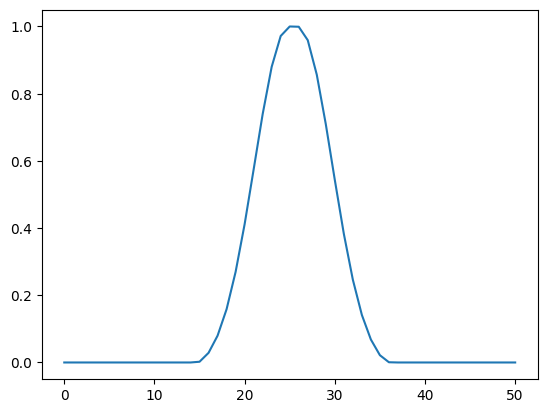

In [309]:
plt.plot(h[int(nx//2),:])
#plt.colorbar()

In [324]:
#np.save('xopt_pAAA.npy', x)
np.save('xopt_pAAA_fit_p_gaussian_h_bg_corr.npy', x)

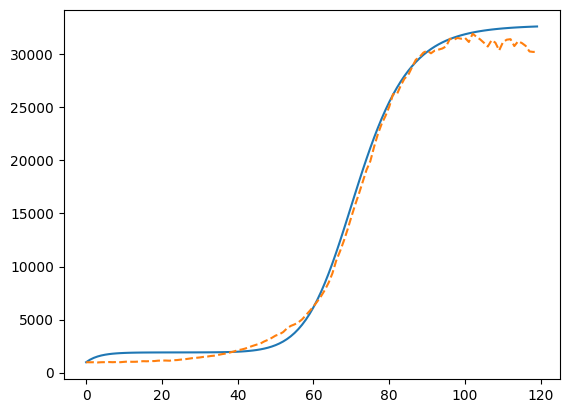

In [325]:
plt.plot(p[:,int(nx//2),int(ny//2),0]) #, aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.plot(crop_im[tidx0:tidx1,int(nx//2),int(ny//2),0], '--') # , aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
#plt.colorbar()

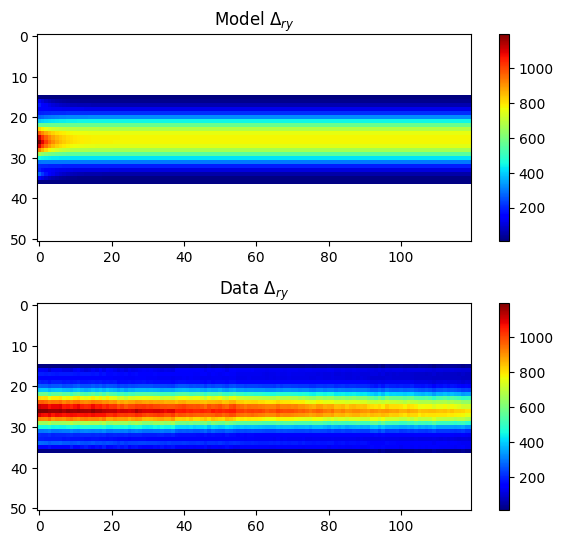

In [596]:
plt.figure(figsize=(6,8))

idx0 = int(12 * 60 * 60 // dt // 120)
idx1 = int(32 * 60 * 60 // dt // 120)

plt.subplot(3,1,1)
plt.imshow(p[:,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet') #, vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.title('Model $\Delta_{ry}$')
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(crop_im[idx0:idx1,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet') #, vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.title('Data $\Delta_{ry}$')
plt.colorbar()

plt.tight_layout()

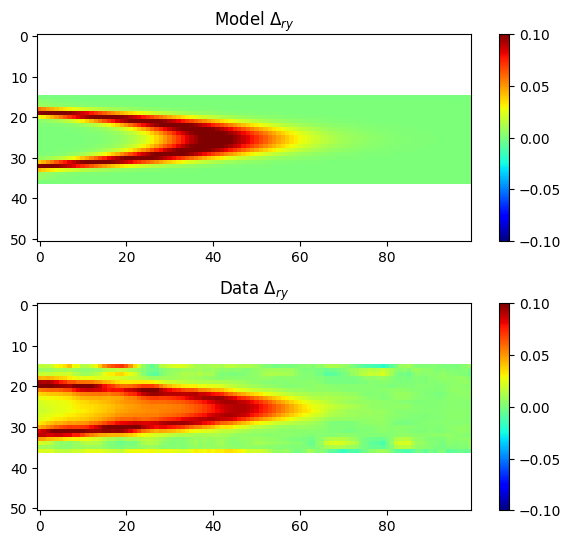

In [315]:
plt.figure(figsize=(6,8))

idx0 = int(12 * 60 * 60 // dt // 120)
idx1 = int(32 * 60 * 60 // dt // 120)

plt.subplot(3,1,1)
plt.imshow(mdslrho[20:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.title('Model $\Delta_{ry}$')
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(dslrho_01[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.title('Data $\Delta_{ry}$')
plt.colorbar()

plt.tight_layout()

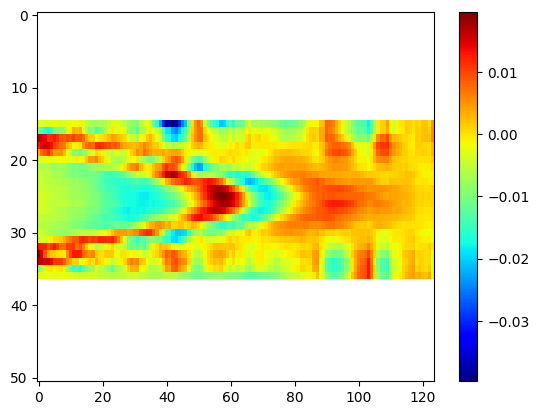

In [81]:
err01 = mdslrho[:,int(nx//2),:] - dslrho_01[idx0+20:idx1,int(nx//2),:]

plt.imshow(err01.transpose(), aspect='auto', cmap='jet')
plt.colorbar()